In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pybamm

## Import parameters from BPX JSON file

In [2]:
parameter_values = pybamm.ParameterValues.create_from_bpx("lfp_18650_cell_BPX.json")

## Parameter values
Here we display the parameter values and plot the functional form of selected parameters.

In [3]:
# table of parameters
pd.DataFrame.from_dict(parameter_values._dict_items, columns=["Value"], orient="index")

,Value
Electrode area [m2],0.0896
External surface area [m2],0.00431
Volume [m3],0.000017
Number of electrode pairs connected in parallel to make a cell,1
Lower voltage cut-off [V],2.0
...,...
Positive electrode OCP entropic change [V.K-1],<function _bpx_to_param_dict.<locals>._positiv...
Negative electrode exchange-current density [A.m-2],<function _bpx_to_param_dict.<locals>._negativ...
Positive electrode exchange-current density [A.m-2],<function _bpx_to_param_dict.<locals>._positiv...
Initial concentration in negative electrode [mol.m-3],25829.012


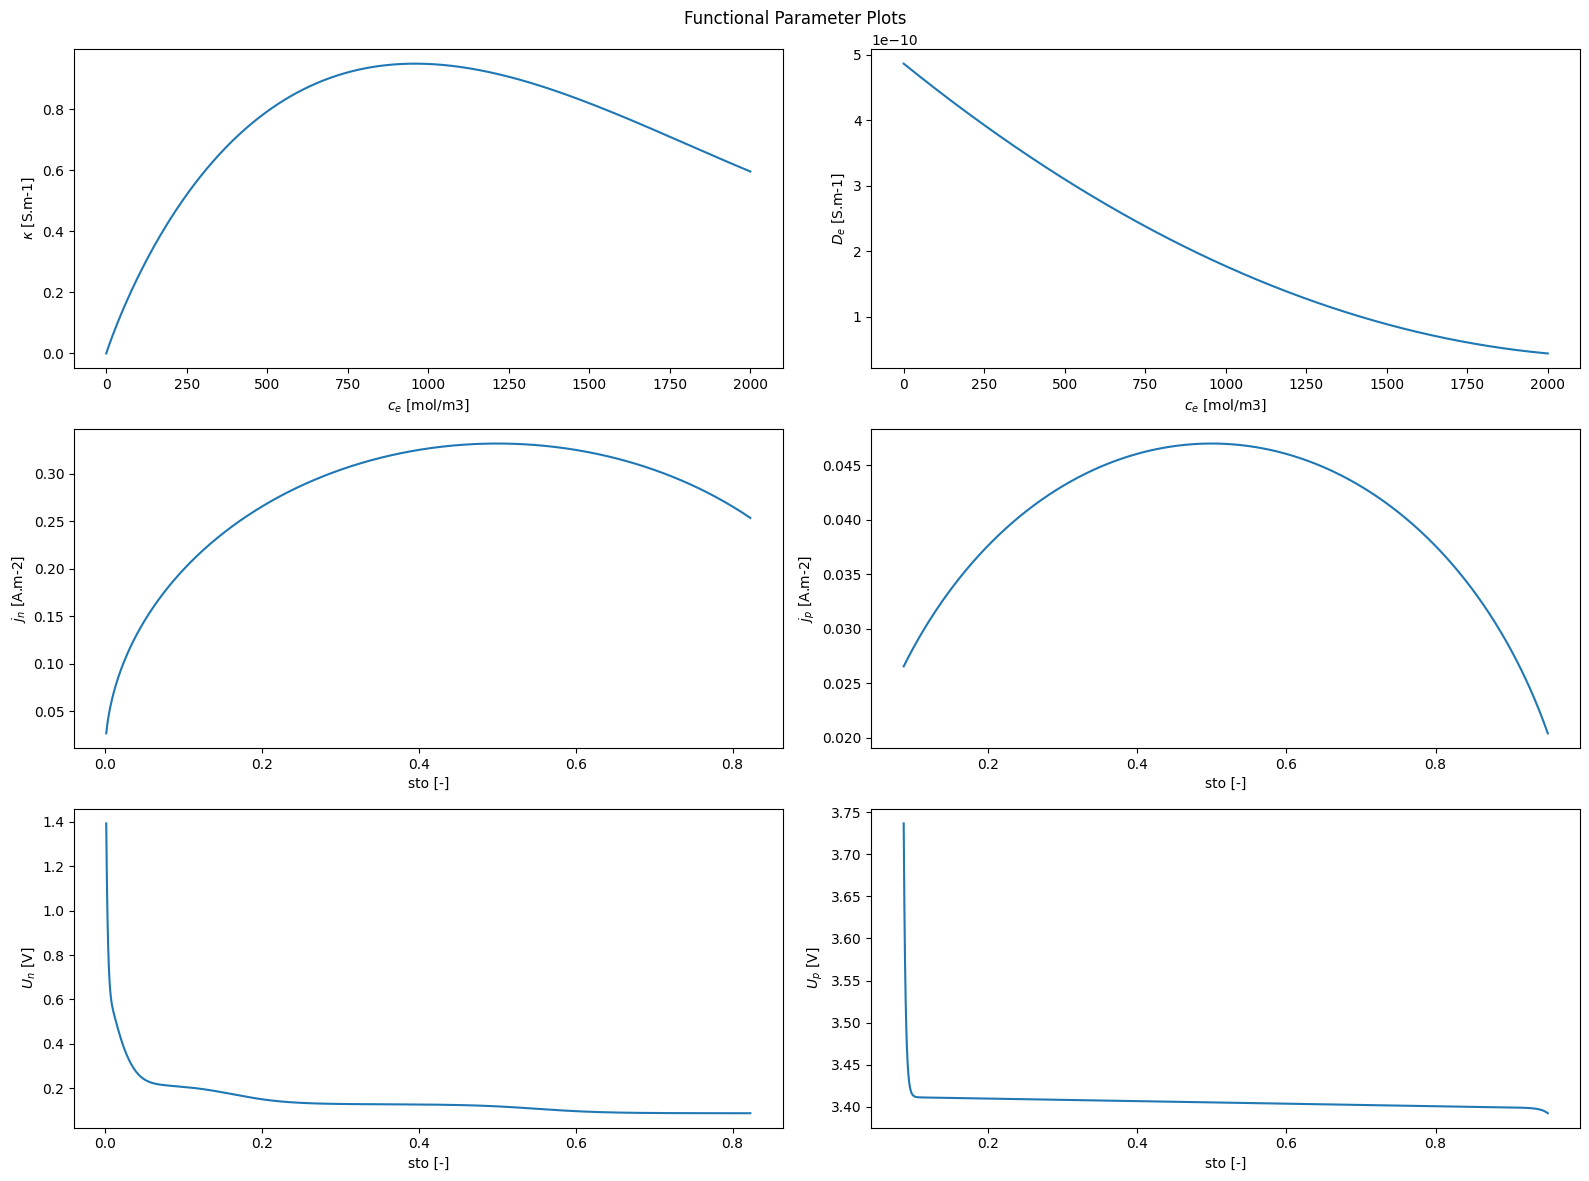

In [4]:
# plot some parameters as a function of sto/concentration

# Define stoichiometry ranges
xLi_n_max = parameter_values["Negative electrode maximum stoichiometry"]
xLi_n_min = parameter_values["Negative electrode minimum stoichiometry"]
xLi_n = pybamm.linspace(xLi_n_min, xLi_n_max, 1000)
xLi_p_max = parameter_values["Positive electrode maximum stoichiometry"]
xLi_p_min = parameter_values["Positive electrode minimum stoichiometry"]
xLi_p = pybamm.linspace(xLi_p_min, xLi_p_max, 1000)

# Define concentration ranges
c_n_max = parameter_values["Maximum concentration in negative electrode [mol.m-3]"]
c_p_max = parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
c_n = xLi_n * c_n_max
c_p = xLi_p * c_p_max
c_e = pybamm.linspace(0, 2000, 1000)

c_e_ref = parameter_values["Typical electrolyte concentration [mol.m-3]"]
T = parameter_values["Reference temperature [K]"]

fig, ax = plt.subplots(3, 2, figsize=(16, 12))
plt.suptitle("Functional Parameter Plots")

ax[0, 0].plot(c_e.entries, parameter_values.evaluate(parameter_values["Electrolyte conductivity [S.m-1]"](c_e, T)))
ax[0, 0].set(xlabel="$c_e$ [mol/m3]", ylabel="$\kappa$ [S.m-1]")
ax[0, 1].plot(c_e.entries, parameter_values.evaluate(parameter_values["Electrolyte diffusivity [m2.s-1]"](c_e, T)))
ax[0, 1].set(xlabel="$c_e$ [mol/m3]", ylabel="$D_e$ [S.m-1]")
ax[1, 0].plot(xLi_n.entries, parameter_values.evaluate(parameter_values["Negative electrode exchange-current density [A.m-2]"](c_e_ref, c_n, c_n_max, T)))
ax[1, 0].set(xlabel="sto [-]", ylabel="$j_n$ [A.m-2]")
ax[1, 1].plot(xLi_p.entries, parameter_values.evaluate(parameter_values["Positive electrode exchange-current density [A.m-2]"](c_e_ref, c_p, c_p_max, T)))
ax[1, 1].set(xlabel="sto [-]", ylabel="$j_p$ [A.m-2]")
ax[2, 0].plot(xLi_n.entries, parameter_values["Negative electrode OCP [V]"](xLi_n).entries)
ax[2, 0].set(xlabel="sto [-]", ylabel="$U_n$ [V]")
ax[2, 1].plot(xLi_p.entries, parameter_values["Positive electrode OCP [V]"](xLi_p).entries)
ax[2, 1].set(xlabel="sto [-]", ylabel="$U_p$ [V]")

plt.tight_layout()

